### Dataset Preparation and Label Structuring


A.1 In this notebook, I work with multiple traffic sign classification datasets, which I merged and arranged into a unified folder structure suitable for training with FastAI’s `DataBlock` API.


In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ahemateja19bec1025/traffic-sign-dataset-classification
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

!unzip -q traffic-sign-dataset-classification.zip -d traffic1
!unzip -q gtsrb-german-traffic-sign.zip -d traffic2


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ahemateja19bec1025/traffic-sign-dataset-classification
License(s): CC0-1.0
 59% 112M/190M [00:00<00:00, 1.17GB/s]
100% 190M/190M [00:00<00:00, 1.24GB/s]
Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
 86% 526M/612M [00:00<00:00, 1.38GB/s]
100% 612M/612M [00:00<00:00, 1.37GB/s]


#### Steps Followed:

- Two different Kaggle datasets were downloaded:
  - `traffic-sign-dataset-classification`
  - `gtsrb-german-traffic-sign`
- Both datasets were unzipped and their training folders were parsed.
- Images from these datasets were copied and merged into a single directory:  
  `/content/data/merged/`, where each traffic sign class was placed into its corresponding labeled folder (e.g. `0/`, `1/`, ..., `42/`).
- Additionally, a mapping dictionary (`class_map`) was created to associate original dataset class names with standardized numerical labels, ensuring consistency between sources.

This structure allows FastAI to infer class labels from folder names via `parent_label`, enabling straightforward training and validation setup using FastAI’s high-level abstractions.

In [ ]:
!kaggle datasets download -d ezzzio/random-images

!unzip -q random-images.zip -d /content

Dataset URL: https://www.kaggle.com/datasets/ezzzio/random-images
License(s): GPL-2.0
  0% 0.00/31.7M [00:00<?, ?B/s]
100% 31.7M/31.7M [00:00<00:00, 1.27GB/s]


In [ ]:
!cp /content/dataset/train/* /content/data/merged/Unknown/


Additionally, unrelated images were merged under the "Unknown" class to help the model better distinguish traffic signs from out-of-distribution (OOD) inputs.









In [ ]:
class_map = {
    "1": ("Speed_limit_30", "2"),
    "2": ("Speed_limit_50", "4"),
    "3": ("Speed_limit_60", "5"),
    "4": ("Speed_limit_70", "6"),
    "5": ("Speed_limit_80", "7"),
    "13": ("Yield", "53"),
    "14": ("Stop", "14"),
    "17": ("No_entry", "55"),
    "26": ("Traffic_signals", "33"),
    "27": ("Pedestrian_crossing", "35"),
    "28": ("Children_crossing", "37"),
    "29": ("Bicycles_crossing", "30"),
    "25": ("Roadwork", "48"),
    "33": ("Go_right", "24"),
    "34": ("Go_left", "22"),
    "35": ("Go_straight", "21"),
    "36": ("Go_straight_or_right", "20"),
    "37": ("Go_left_or_right", "23"),
    "38": ("Keep_right", "26"),
    "40": ("Roundabout", "27")
}

In [ ]:
import os
import shutil
from pathlib import Path


gtsrb_base = Path('traffic2/train')
hemateja_base = Path('/content/traffic1/traffic_Data/DATA')
output_base = Path('data/merged')
output_base.mkdir(parents=True, exist_ok=True)

for gtsrb_id, (class_name, hemateja_id) in class_map.items():

    class_path = output_base / class_name
    class_path.mkdir(exist_ok=True)

    gtsrb_class_dir = gtsrb_base / gtsrb_id
    if gtsrb_class_dir.exists():
        for file in gtsrb_class_dir.iterdir():
            shutil.copy(file, class_path / f'gtsrb_{file.name}')

    hemateja_class_dir = hemateja_base / hemateja_id
    if hemateja_class_dir.exists():
        for file in hemateja_class_dir.iterdir():
            shutil.copy(file, class_path / f'hemateja_{file.name}')


A1.1 Inspect the data layout

In [ ]:
path = Path('/content/data/merged')
folders = sorted([f for f in path.iterdir() if f.is_dir()])
labels = [f.name for f in folders[:5]]

print(f"Total merged classes: {len(folders)}")
print(f"Example merged class names: {labels}")


Total merged classes: 22
Example merged class names: ['.ipynb_checkpoints', 'Bicycles_crossing', 'Children_crossing', 'Go_left', 'Go_left_or_right']


A 1.2 In this section, I structured the dataset and configured the FastAI DataBlock for training a traffic sign classification model. The merged dataset directory contains subfolders where each folder represents a distinct traffic sign class. Additionally, an "Unknown" folder includes unrelated images, contributing to the model's ability to distinguish valid signs from non-sign content. The data was loaded using get_image_files, and labels were inferred from folder names using parent_label. A 20% validation split was applied using RandomSplitter. For preprocessing, a two-stage image transformation strategy was used. Images were first resized (presized) to a slightly larger dimension to preserve structure during augmentations. Then, several data augmentation techniques were applied: rotation, zoom, lighting adjustments, and warping. Vertical and horizontal flips were disabled to preserve the meaning of direction-sensitive signs. The full pipeline was wrapped in a DataBlock, which was then converted into DataLoaders with a batch size of 32 and 2 workers to enable parallel loading during training.

In [ ]:
from fastai.vision.all import *


img_size = 224
presize_val = int(img_size * 1.5)

item_tfms = [Resize(presize_val), RandomResizedCrop(img_size, min_scale=0.75)]

batch_tfms = aug_transforms(
    mult=1.0,
    flip_vert=False,
    do_flip=False,
    max_rotate=20.0,
    max_zoom=1.2,
    max_lighting=0.3,
    max_warp=0.1
)


dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.20, seed=42),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

dls = dblock.dataloaders(path, bs=32, num_workers=2)

A.3.1 Show batch

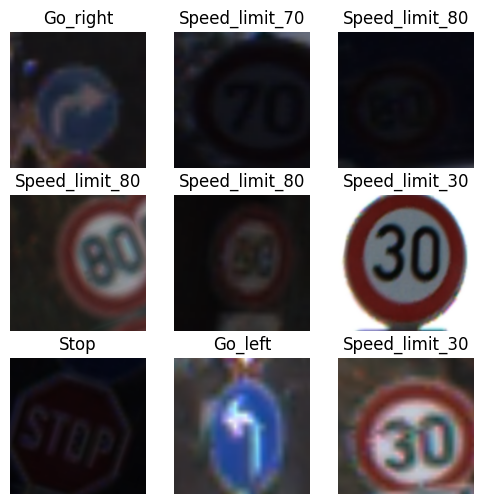

In [ ]:
dls.show_batch(max_n=9, figsize=(6,6))

A.3.2 Check the labels



In [ ]:
print(dls.vocab)

['Bicycles_crossing', 'Children_crossing', 'Go_left', 'Go_left_or_right', 'Go_right', 'Go_straight', 'Go_straight_or_right', 'Keep_right', 'No_entry', 'Pedestrian_crossing', 'Roadwork', 'Roundabout', 'Speed_limit_30', 'Speed_limit_50', 'Speed_limit_60', 'Speed_limit_70', 'Speed_limit_80', 'Stop', 'Traffic_signals', 'Unknown', 'Yield']


A.3.3 summary()

In [ ]:
dblock.summary(path)

Setting-up type transforms pipelines
Found 30316 items
2 datasets of sizes 24253,6063
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/data/merged/Pedestrian_crossing/gtsrb_00027_00006_00004.png
    applying PILBase.create gives
      PILImage mode=RGB size=43x40
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/data/merged/Pedestrian_crossing/gtsrb_00027_00006_00004.png
    applying parent_label gives
      Pedestrian_crossing
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(9)

Final sample: (PILImage mode=RGB size=43x40, TensorCategory(9))


Found 30316 items
2 datasets of sizes 24253,6063
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort':

**Pipeline Setup Summary (FastAI)**

Total Items: 30,316 images found under /content/data/merged, automatically split into:

24,253 training samples

6,063 validation samples (via RandomSplitter)


A.4.1 Create a benchmark

In [ ]:
from fastai.metrics import accuracy, F1Score, BalancedAccuracy

learn = vision_learner(dls, resnet34, metrics=[accuracy, BalancedAccuracy(), F1Score(average='macro')])
learn.fine_tune(epochs=4)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,f1_score,time
0,0.550303,0.287637,0.898400,0.872360,0.871508,01:05


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,f1_score,time
0,0.088245,0.056604,0.983012,0.979053,0.980280,01:05
1,0.037513,0.014026,0.995052,0.995580,0.996190,01:05
2,0.013121,0.005771,0.998516,0.998807,0.998906,01:05
3,0.008063,0.001945,0.999175,0.999476,0.999430,01:05


A.4.2 Interpret the model

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


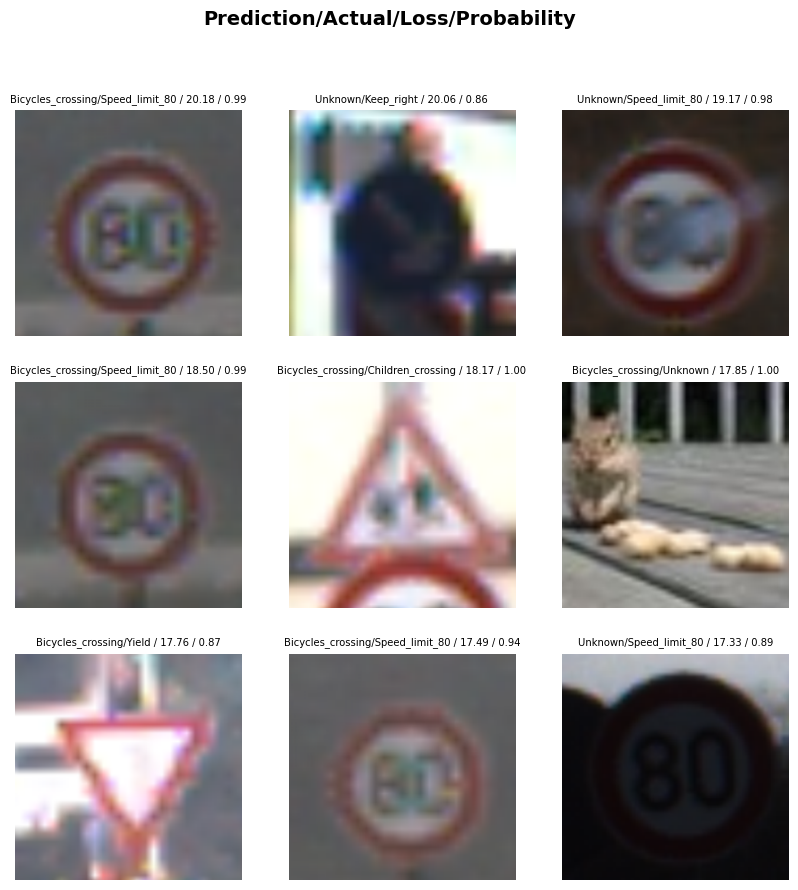

In [ ]:

interp = ClassificationInterpretation.from_learner(learn)
plt.rcParams.update({'font.size': 6})
interp.plot_top_losses(9, nrows=3, figsize=(10, 10))


A.4.3 Confusion matrix

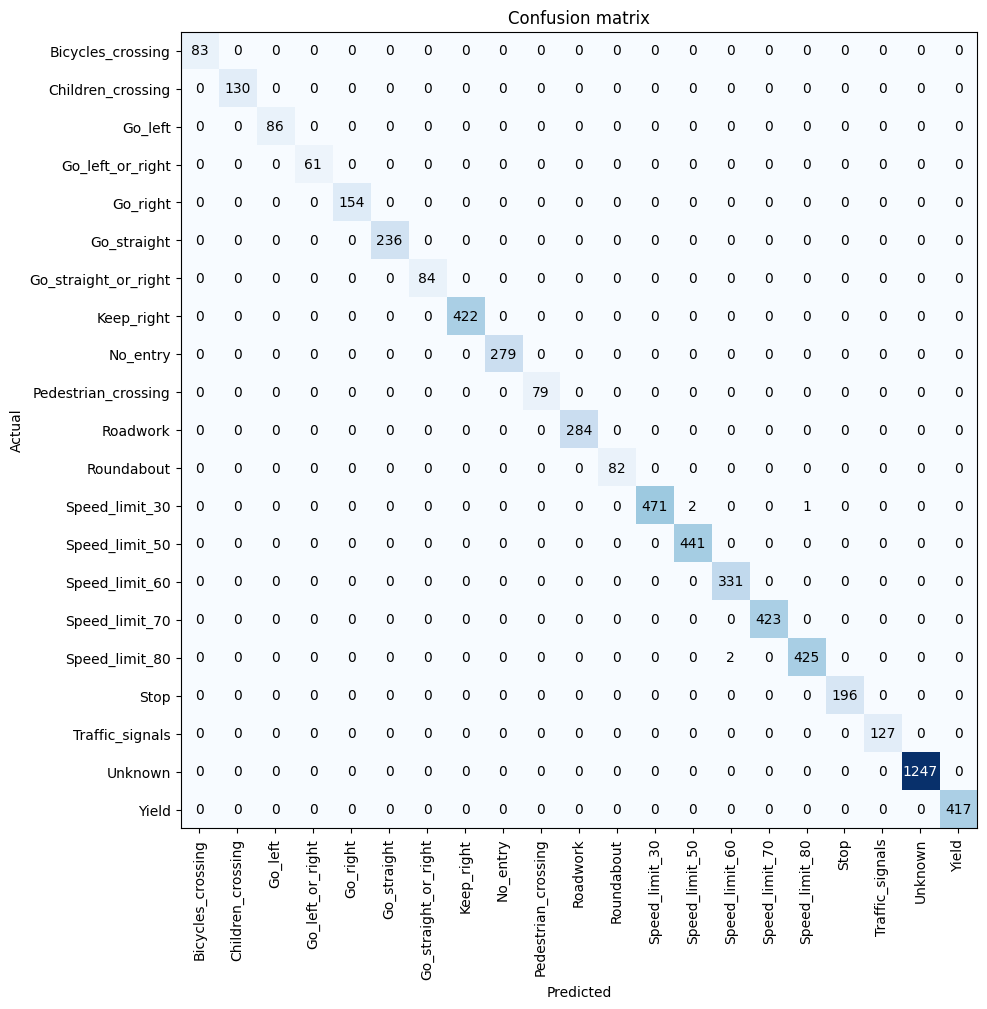

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10))

 B.1. Learning Rate Finder

Large Learning Rate

In [ ]:
learnR = vision_learner(dls, resnet34, metrics=[accuracy, BalancedAccuracy(), F1Score(average='macro')])
learn.fit_one_cycle(5, lr_max=1e-1)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,f1_score,time
0,4.493362,3.856301,0.062016,0.041212,0.011984,01:05
1,3.274252,245467.031250,0.029193,0.068607,0.009897,01:04
2,1.676051,55.282879,0.587498,0.429084,0.384625,01:05
3,0.626351,0.668894,0.870691,0.837806,0.847866,01:04
4,0.319353,0.538800,0.952169,0.934520,0.934139,01:05


Small Learning Rate

In [ ]:
learnR = vision_learner(dls, resnet34, metrics=[accuracy, BalancedAccuracy(), F1Score(average='macro')])
learn.fit_one_cycle(5, lr_max=1e-6)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,f1_score,time
0,0.290944,0.316465,0.951179,0.933833,0.933743,01:05
1,0.274990,0.275121,0.953488,0.935410,0.935835,01:05
2,0.269697,0.263274,0.953653,0.936640,0.937034,01:05
3,0.290924,0.294462,0.952169,0.935202,0.935605,01:05
4,0.311008,0.225170,0.953983,0.936420,0.937131,01:05


B.2. Finder Algorithm

In [ ]:
from torch.optim import SGD
import matplotlib.pyplot as plt

learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.unfreeze()
learn.model.train()
learn.model = learn.model.to('cuda')

lrs, losses = [], []
lr = 1e-5

for i in range(100):
    xb, yb = dls.one_batch()
    xb, yb = xb.to('cuda'), yb.to('cuda')

    opt = SGD(learn.model.parameters(), lr=lr, momentum=0.9)
    opt.zero_grad()

    preds = learn.model(xb)
    loss = CrossEntropyLossFlat()(preds, yb)
    loss.backward()
    opt.step()

    lrs.append(lr)
    losses.append(loss.item())

    lr *= 1.4

    if i > 5 and loss.item() > 10: break


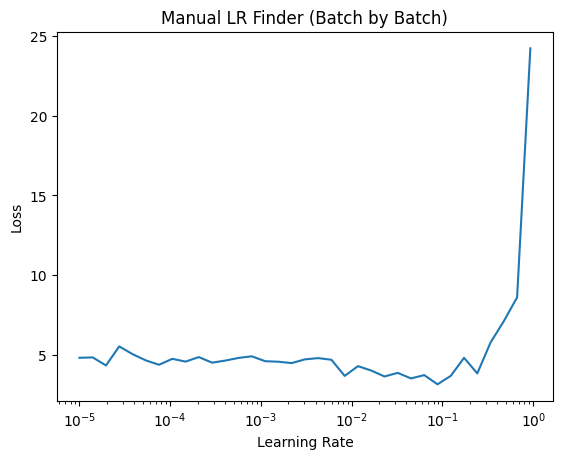

In [ ]:
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Manual LR Finder (Batch by Batch)")
plt.show()

SuggestedLRs(valley=0.0006918309954926372, slide=0.0030199517495930195, steep=0.005248074419796467)

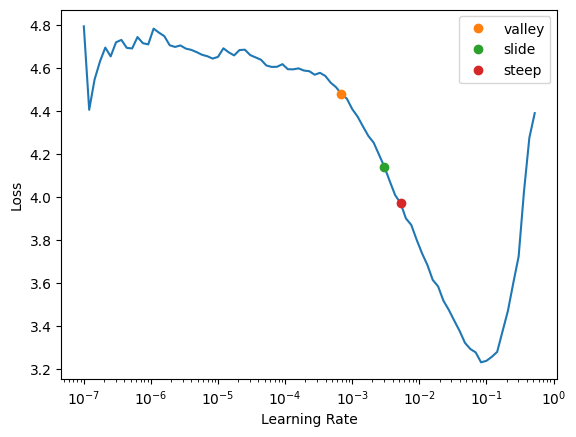

In [ ]:
from fastai.callback.schedule import valley, slide, steep
learn = vision_learner(dls, resnet34, metrics=[accuracy, BalancedAccuracy(), F1Score(average='macro')])
learn.lr_find(suggest_funcs=[valley, slide, steep])

In [ ]:
lr = slice(1e-4, 1e-2)

B.3. Transfer Learning (Freeze / Unfreeze)

In [ ]:
learn.freeze()
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,f1_score,time
0,0.235870,0.092757,0.970807,0.966707,0.968245,01:05
1,0.083619,0.023671,0.992083,0.991830,0.992501,01:05
2,0.053652,0.016077,0.993732,0.993985,0.994111,01:06


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, lr_max=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,f1_score,time
0,0.389549,0.536360,0.882072,0.860709,0.836658,01:05
1,0.082443,0.016939,0.995712,0.995129,0.994291,01:06
2,0.052626,0.017772,0.995712,0.995454,0.995549,01:05
3,0.009041,0.001820,0.999340,0.999561,0.999548,01:05
4,0.004918,0.001121,0.999835,0.999892,0.999890,01:05


B.4. Discriminative Learning Rates

In [ ]:
learn.fit_one_cycle(4, lr_max=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.267062,0.154909,0.957777,00:27
1,0.145896,0.029202,0.991258,00:27
2,0.040954,0.012328,0.995877,00:27
3,0.021861,0.005101,0.998021,00:27


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


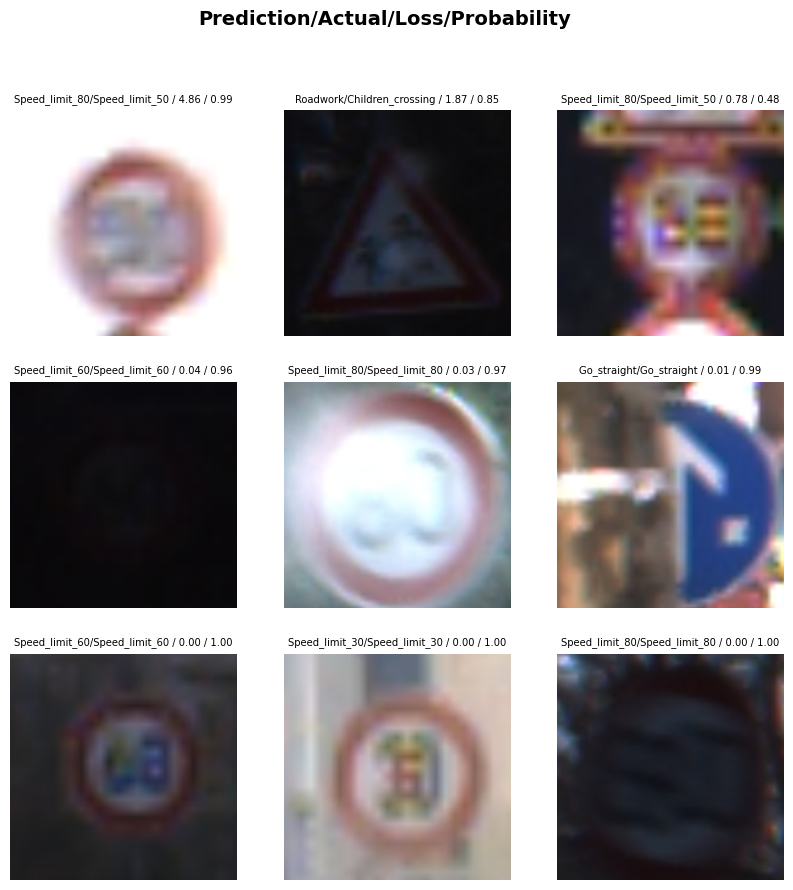

In [ ]:
from fastai.interpret import ClassificationInterpretation
plt.rcParams.update({'font.size': 6})

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, nrows=3, figsize=(10,10))


 B.6. Model Capacity

In [ ]:
dls = dblock.dataloaders(path, bs=32)

learn = vision_learner(dls, resnet50, metrics=[accuracy, BalancedAccuracy(), F1Score(average='macro')])
learn = learn.to_fp16()
learn.freeze()
learn.fit_one_cycle(3, lr_max=1e-3)

learn.unfreeze()
learn.fit_one_cycle(5, lr_max=slice(1e-4, 1e-2))


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,f1_score,time
0,0.004129,0.001813,0.999505,0.999425,0.999517,01:06
1,0.005732,0.000877,0.999505,0.999425,0.999517,01:05
2,0.000409,0.000988,0.999505,0.999425,0.999517,01:05


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,f1_score,time
0,0.046325,0.011993,0.996536,0.992300,0.994840,01:05
1,0.084778,0.002737,0.999670,0.999322,0.999590,01:06
2,0.017875,0.017535,0.997856,0.998529,0.998502,01:06
3,0.009016,0.004137,0.999340,0.999544,0.999534,01:05
4,0.007630,0.000746,0.999670,0.999781,0.999763,01:05


In [ ]:
learn.export('gtsrb_model.pkl')

B.7. Weight Initialization

In [ ]:
from fastai.vision.all import *

path = Path('data/merged')

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(64),
    batch_tfms=aug_transforms(size=64)
)

dls = dblock.dataloaders(path, bs=64)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init_fn

class SimpleCNN(nn.Module):
    def __init__(self, init_type='kaiming'):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*16*16, 128)
        self.fc2 = nn.Linear(128, 22)

        self.init_weights(init_type)

    def init_weights(self, init_type):
        if init_type == 'kaiming':
            init_fn.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
            init_fn.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
            init_fn.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
            init_fn.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        elif init_type == 'xavier':
            init_fn.xavier_uniform_(self.conv1.weight)
            init_fn.xavier_uniform_(self.conv2.weight)
            init_fn.xavier_uniform_(self.fc1.weight)
            init_fn.xavier_uniform_(self.fc2.weight)
        elif init_type == 'orthogonal':
            init_fn.orthogonal_(self.conv1.weight)
            init_fn.orthogonal_(self.conv2.weight)
            init_fn.orthogonal_(self.fc1.weight)
            init_fn.orthogonal_(self.fc2.weight)

        for m in [self.conv1, self.conv2, self.fc1, self.fc2]:
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
def train_model(init_type='kaiming'):
    model = SimpleCNN(init_type)
    learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
    learn.fit(5)
    return learn

In [ ]:
results = {}

for init_type in ['kaiming', 'xavier', 'orthogonal']:
    print(f"\nTraining with {init_type} initialization")
    learn = train_model(init_type)
    acc = learn.validate()[1]
    results[init_type] = acc

print("\n--- Accuracy Results ---")
for k, v in results.items():
    print(f"{k}: {v:.4f}")


Training with kaiming initialization


epoch,train_loss,valid_loss,accuracy,time
0,1.041514,0.814718,0.707241,00:11
1,0.747243,0.594711,0.790698,00:11
2,0.604187,0.420810,0.846116,00:11
3,0.517690,0.339229,0.894607,00:11
4,0.471385,0.311576,0.903348,00:11



Training with xavier initialization


epoch,train_loss,valid_loss,accuracy,time
0,0.998631,0.758517,0.751938,00:11
1,0.708012,0.526902,0.827643,00:11
2,0.543150,0.403854,0.860465,00:11
3,0.473341,0.290171,0.911595,00:11
4,0.398809,0.233355,0.923140,00:11



Training with orthogonal initialization


epoch,train_loss,valid_loss,accuracy,time
0,0.960815,0.723966,0.752763,00:11
1,0.680932,0.455435,0.851064,00:11
2,0.544225,0.389275,0.867557,00:11
3,0.447500,0.318861,0.884051,00:11
4,0.376733,0.246544,0.911100,00:11



--- Accuracy Results ---
kaiming: 0.9033
xavier: 0.9231
orthogonal: 0.9111


Transfer Learning Model Weight Change B7.5

In [ ]:
learn = vision_learner(dls, resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]


In [ ]:
import torch.nn as nn
import torch.nn.init as init_fn

def custom_weight_init(m):
    if isinstance(m, nn.Linear):
        if m.weight is not None:
            nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [ ]:
learn.model[1].apply(custom_weight_init)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=4096, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=21, bias=False)
)

In [ ]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.076078,0.703699,0.764968,00:23


epoch,train_loss,valid_loss,accuracy,time
0,0.423709,0.225004,0.922151,00:27
1,0.166480,0.080211,0.971301,00:27
2,0.091130,0.066487,0.979548,00:27
3,0.050646,0.022848,0.992248,00:27
4,0.034056,0.018730,0.994227,00:27


In [ ]:
acc = learn.validate()[1]
print(f"Accuracy with Xavier initialization on head: {acc:.4f}")

Accuracy with Xavier initialization on head: 0.9980


In [ ]:
import torch.nn as nn
import torch.nn.init as init

def kaiming_init_head(learn):
    for m in learn.model.modules():
        if isinstance(m, nn.Linear):
            if m.weight is not None:
                init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

In [ ]:
learn = vision_learner(dls, resnet50, metrics=accuracy)
kaiming_init_head(learn)

In [ ]:
learn.fine_tune(5)
acc = learn.validate()[1]
print(f"Kaiming init (head only) accuracy: {acc:.4f}")

epoch,train_loss,valid_loss,accuracy,time
0,1.124766,0.704503,0.765463,00:23


epoch,train_loss,valid_loss,accuracy,time
0,0.409312,0.215018,0.921821,00:27
1,0.166676,0.081078,0.969817,00:27
2,0.090809,0.036713,0.985981,00:27
3,0.047384,0.023669,0.992083,00:27
4,0.037953,0.020126,0.992578,00:27


Kaiming init (head only) accuracy: 0.9926
